# How to visualize distance to a point in a mesh?

In this notebook, we consider different distance functions on a metric and visualize the results.

In [ ]:
import geomstats.backend as gs
import pyvista as pv

from geomfum.dataset import NotebooksDataset
from geomfum.metric.mesh import (
    GraphShortestPathMetric,
    HeatDistanceMetric,
    KClosestGraphShortestPathMetric,
    VertexEuclideanMetric,
)
from geomfum.shape import TriangleMesh
from geomfum.shape.convert import to_pv_polydata


In [2]:
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

[Load a mesh](00_load_mesh_from_file.ipynb).

In [3]:
dataset = NotebooksDataset()
mesh = TriangleMesh.from_file(dataset.get_filename("cat-00"))

mesh.n_vertices, mesh.n_faces

INFO: Data has already been downloaded... using cached file ('C:\Users\giuli\.geomfum\data\cat-00.off').


(7207, 14410)

Instantiate different metrics.

In [4]:
metrics = {
    "euclidean": VertexEuclideanMetric(mesh),
    "heat-distance": HeatDistanceMetric.from_registry(mesh, which="pp3d"),
    "graph": GraphShortestPathMetric(mesh, cutoff=None),
    "graph-with-cutoff": GraphShortestPathMetric(mesh, cutoff=0.1),
    "graph-with-closest": KClosestGraphShortestPathMetric(mesh, k_closest=100),
}

Compute distances from a source node.

In [5]:
index = 10
vertex_indices = gs.arange(mesh.n_vertices)

# bound for the colorbar
max_dist = 0.0

dists_dict = {}
for name, metric in metrics.items():
    print(metric)
    dists_, target = metric.dist_from_source(index)

    max_dist_ = gs.amax(dists_)
    if max_dist_ > max_dist:
        max_dist = max_dist_

    indices = gs.arange(mesh.n_vertices)
    dists = float("inf") * gs.ones(mesh.n_vertices)
    dists[target] = dists_

    dists_dict[name] = dists

The following is also valid code, but much slower for graph shortest path-based metrics. Can guess why?

```python
dists = metric.dist(index, vertex_indices)
```

Plot using `pyvista`.

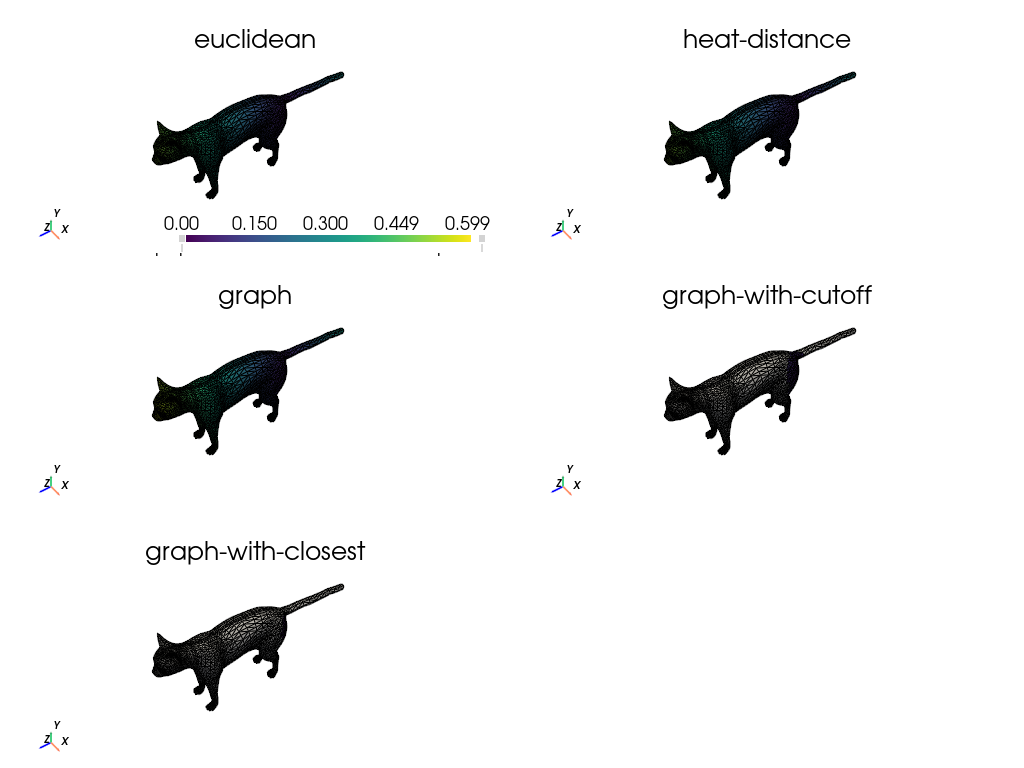

In [7]:
inf_color = "lightgray"
pv_mesh = to_pv_polydata(mesh)

n_cols = 2

n_dists = len(dists_dict)
n_rows = int(n_dists / n_cols + n_dists % n_cols)


pl = pv.Plotter(shape=(n_rows, n_cols), border=False)

for index, (name, dists) in enumerate(dists_dict.items()):
    row, col = index // n_cols, index % n_cols
    pl.subplot(row, col)

    pl.show_axes()
    pl.add_mesh(
        pv_mesh,
        show_edges=True,
        scalars=dists,
        clim=[0, max_dist],
        below_color=inf_color,
        above_color=inf_color,
        copy_mesh=True,
    )

    pl.camera.roll = 0
    pl.camera.azimuth = 10
    pl.camera.elevation = 10
    pl.add_title(name, font_size=10)

pl.show()